C:\Users\Ayush Agrawal\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - loss: 300507.3438 - val_loss: 288642.6250
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 308734.1250 - val_loss: 288277.8750
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 295822.6562 - val_loss: 287889.8750
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 278905.2500 - val_loss: 287460.3750
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 298893.3750 - val_loss: 286977.6875
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 290848.0312 - val_loss: 286449.7500
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 313297.8125 - val_loss: 285863.3438
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 268846.2500 - val_loss: 285197.7812
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 299570.4688 - val_loss: 284428.8438
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 299198.2188 - val_loss: 283538.9688
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 296064.031

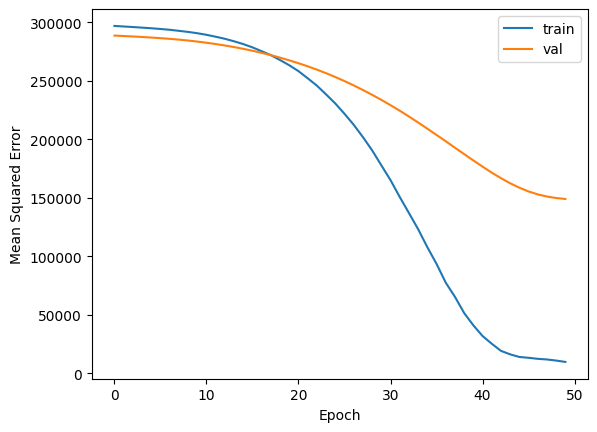

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Mean Squared Error on Test Set: 124400.2734375


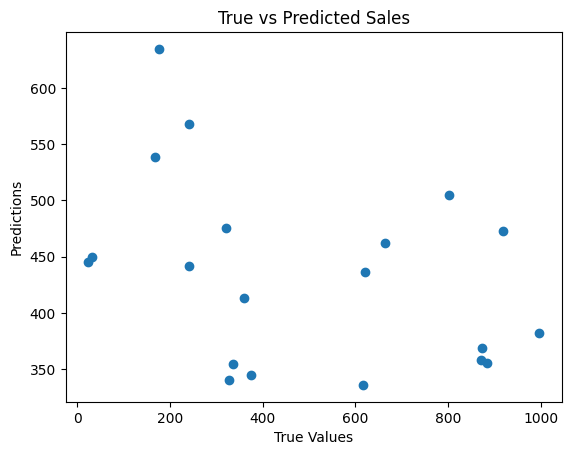

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

🎯 Predicted Sales: 334.34


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load dataset
df = pd.read_csv('supply_chain_data_modified.csv')

# Add synthetic Date column
start_date = pd.to_datetime("2024-01-01")
df['Date'] = [start_date + timedelta(days=i) for i in range(len(df))]

# Rename columns
df.rename(columns={
    'SKU': 'ProductID',
    'Number of products sold': 'HistoricalSales'
}, inplace=True)

# Add synthetic features
np.random.seed(42)
df['Promotion'] = np.random.choice([0, 1], size=len(df))
df['Weather'] = np.random.choice(['Sunny', 'Rainy', 'Cloudy'], size=len(df))
df['EconomicIndicators'] = np.random.choice(['High', 'Medium', 'Low'], size=len(df))

# Strip column names
df.columns = df.columns.str.strip()

# Drop missing values
df.dropna(inplace=True)

# Convert 'Date' to datetime and extract date-based features
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Quarter'] = df['Date'].dt.quarter
df.drop(columns=['Date'], inplace=True)

# One-hot encode all object columns
object_cols = df.select_dtypes(include='object').columns.tolist()
df = pd.get_dummies(df, columns=object_cols, drop_first=True)

# Define target and features
target = 'HistoricalSales'
X = df.drop(columns=[target])
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Align test set to train set
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Save feature names for future use
feature_names = X_train.columns

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the model
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[X_train_scaled.shape[1]]),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, validation_split=0.2)

# Plot training and validation loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# Evaluate the model
test_predictions = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, test_predictions)
print(f'Mean Squared Error on Test Set: {mse}')

# Plot true vs predicted values
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Sales')
plt.show()

# Save the model
model.save('demand_forecasting_model.keras')

# Load the model for future predictions
loaded_model = keras.models.load_model('demand_forecasting_model.keras')

# Example new input (you should prepare same-length feature vector)
new_data = np.array([[0.5, 1.2, 0.3, 0, 1, 0, 0, 0, 1]])

# Create partial DataFrame with feature names (padding others with 0)
partial_input = pd.DataFrame([new_data[0]], columns=feature_names[:9])
full_input = partial_input.reindex(columns=feature_names, fill_value=0)

# Scale and predict
new_data_scaled = scaler.transform(full_input)
predicted_sales = loaded_model.predict(new_data_scaled)
print(f'\n🎯 Predicted Sales: {predicted_sales[0][0]:.2f}')


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 144 entries, Price to EconomicIndicators_Medium
dtypes: bool(125), float64(6), int32(3), int64(10)
memory usage: 26.0 KB


In [5]:
print(df.columns)

Index(['Price', 'Availability', 'HistoricalSales', 'Revenue generated',
       'Stock levels', 'Lead times', 'Order quantities', 'Shipping times',
       'Shipping costs', 'Lead time',
       ...
       'Inspection results_Pending', 'Transportation modes_Rail',
       'Transportation modes_Road', 'Transportation modes_Sea',
       'Routes_Route B', 'Routes_Route C', 'Weather_Rainy', 'Weather_Sunny',
       'EconomicIndicators_Low', 'EconomicIndicators_Medium'],
      dtype='object', length=144)


In [7]:
import duckdb

query = """
SELECT SUM("Revenue generated")::DECIMAL(8,2) AS total_revenue
FROM df
"""
result = duckdb.query(query).df()
print(result)

   total_revenue
0      577604.82
